In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [2]:
import zarr

import l5kit
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='jshtml')
print("l5kit version:", l5kit.__version__)

l5kit version: 1.1.0


In [3]:
os.environ["L5KIT_DATA_FOLDER"] = "/kaggle/input/lyft-motion-prediction-autonomous-vehicles"

In [4]:
dm = LocalDataManager()
dataset_path = dm.require('scenes/sample.zarr')
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


### scenes

```
SCENE_DTYPE = [
    ("frame_index_interval", np.int64, (2,)),
    ("host", "<U16"),  # Unicode string up to 16 chars
    ("start_time", np.int64),
    ("end_time", np.int64),
]
```

In [5]:
print("scenes", zarr_dataset.scenes, "\n")

scene = zarr_dataset.scenes[0] # single frame
print("scene", scene, "\n")

print("len(scenes)", len(zarr_dataset.scenes))
print("len(scene)", len(scene), "\n")

print("frame_index_interval", scene[0])
print("host", scene[1])
print("start_time", scene[2])
print("end_time", scene[3])
print("end-start", scene[3]-scene[2], "\n")

scene = zarr_dataset.scenes[1] # single frame
print("frame_index_interval", scene[0])
print("host", scene[1])
print("start_time", scene[2])
print("end_time", scene[3])
print("end-start", scene[3]-scene[2], "\n")

scene = zarr_dataset.scenes[2] # single frame
print("frame_index_interval", scene[0])
print("host", scene[1])
print("start_time", scene[2])
print("end_time", scene[3])
print("end-start", scene[3]-scene[2], "\n")

for i in range(0,3):
    scene = zarr_dataset.scenes[i]
    frame_index_interval = scene[0]
    print("frame_index_interval {}".format(i), frame_index_interval)

scenes <zarr.core.Array '/scenes' (100,) [('frame_index_interval', '<i8', (2,)), ('host', '<U16'), ('start_time', '<i8'), ('end_time', '<i8')] read-only> 

scene ([  0, 248], 'host-a013', 1572643684617362176, 1572643709617362176) 

len(scenes) 100
len(scene) 4 

frame_index_interval [  0 248]
host host-a013
start_time 1572643684617362176
end_time 1572643709617362176
end-start 25000000000 

frame_index_interval [248 497]
host host-a013
start_time 1572643749559148288
end_time 1572643774559148288
end-start 25000000000 

frame_index_interval [497 746]
host host-a013
start_time 1572643774559148288
end_time 1572643799559148288
end-start 25000000000 

frame_index_interval 0 [  0 248]
frame_index_interval 1 [248 497]
frame_index_interval 2 [497 746]


### frames

```
FRAME_DTYPE = [
    ("timestamp", np.int64),
    ("agent_index_interval", np.int64, (2,)),
    ("traffic_light_faces_index_interval", np.int64, (2,)),
    ("ego_translation", np.float64, (3,)),
    ("ego_rotation", np.float64, (3, 3)),
]
```


In [6]:
print("frames", zarr_dataset.frames, "\n")

frame = zarr_dataset.frames[0] # single frame
print("frame", frame, "\n")

print("len(frames)", len(zarr_dataset.frames))
print("len(frame)", len(frame), "\n")

for i in range(0,3):
    frame = zarr_dataset.frames[i]
    ego_translation = frame[3]
    print("ego_translation {}".format(i), ego_translation)


frames <zarr.core.Array '/frames' (24838,) [('timestamp', '<i8'), ('agent_index_interval', '<i8', (2,)), ('traffic_light_faces_index_interval', '<i8', (2,)), ('ego_translation', '<f8', (3,)), ('ego_rotation', '<f8', (3, 3))] read-only> 

frame (1572643684801892606, [ 0, 38], [0, 0], [  680.61975098, -2183.32763672,   288.5411377 ], [[ 0.54673314, -0.83729434,  0.00459086], [ 0.83528739,  0.54502565, -0.07240184], [ 0.05811952,  0.04341917,  0.997365  ]]) 

len(frames) 24838
len(frame) 5 

ego_translation 0 [  680.61975098 -2183.32763672   288.5411377 ]
ego_translation 1 [  681.18560791 -2182.42236328   288.60812378]
ego_translation 2 [  681.76470947 -2181.52270508   288.68093872]


### agents

```
AGENT_DTYPE = [
    ("centroid", np.float64, (2,)),
    ("extent", np.float32, (3,)),
    ("yaw", np.float32),
    ("velocity", np.float32, (2,)),
    ("track_id", np.uint64),
    ("label_probabilities", np.float32, (len(LABELS),)),
]
```


In [7]:
print("agents", zarr_dataset.agents, "\n")

agent = zarr_dataset.agents[0]
print("agent", agent, "\n")

print("len(agents)", len(zarr_dataset.agents))
print("len(agent)", len(agent), "\n")

centroid = agent[0]
extent =   agent[1]
yaw =      agent[2]
print("centroid", centroid)
print("extent", extent)
print("yaw", yaw)

agents <zarr.core.Array '/agents' (1893736,) [('centroid', '<f8', (2,)), ('extent', '<f4', (3,)), ('yaw', '<f4'), ('velocity', '<f4', (2,)), ('track_id', '<u8'), ('label_probabilities', '<f4', (17,))] read-only> 

agent ([  665.03424072, -2207.51220703], [4.3913283, 1.8138304, 1.5909758], 1.0166751, [0., 0.], 1, [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) 

len(agents) 1893736
len(agent) 6 

centroid [  665.03424072 -2207.51220703]
extent [4.3913283 1.8138304 1.5909758]
yaw 1.0166751


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

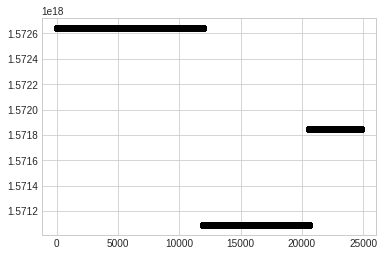

In [9]:
x = []
timestamp = []
for i in range(0, len(zarr_dataset.frames)):
    frame = zarr_dataset.frames[i]
    x.append(i)
    timestamp.append(frame[0])
plt.plot(x, timestamp, 'o', color='black')

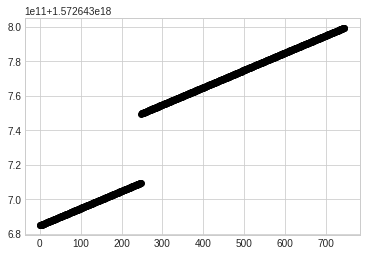

In [10]:
x = []
timestamp = []
for i in range(0, 746):
    frame = zarr_dataset.frames[i]
    x.append(i)
    timestamp.append(frame[0])
plt.plot(x, timestamp, 'o', color='black')

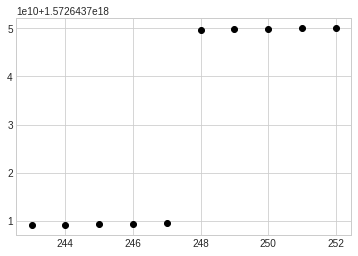

In [11]:
x = []
timestamp = []
for i in range(248-5, 248+5):
    frame = zarr_dataset.frames[i]
    x.append(i)
    timestamp.append(frame[0])
plt.plot(x, timestamp, 'o', color='black')

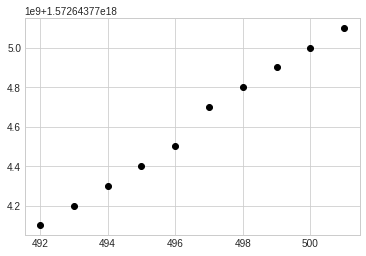

In [12]:
x = []
timestamp = []
for i in range(497-5, 497+5):
    frame = zarr_dataset.frames[i]
    x.append(i)
    timestamp.append(frame[0])
plt.plot(x, timestamp, 'o', color='black')

In [13]:
#x = []
#timestamp = []
for i in range(0, 10):#len(zarr_dataset.frames)):
    frame = zarr_dataset.frames[i]
    #x.append(i)
    #timestamp.append(frame[1])
    agent_index_interval = frame[1]
    print(agent_index_interval, agent_index_interval[1]-agent_index_interval[0])
#plt.plot(x, timestamp, 'o', color='black')

[ 0 38] 38
[38 85] 47
[ 85 142] 57
[142 200] 58
[200 254] 54
[254 307] 53
[307 366] 59
[366 431] 65
[431 500] 69
[500 577] 77


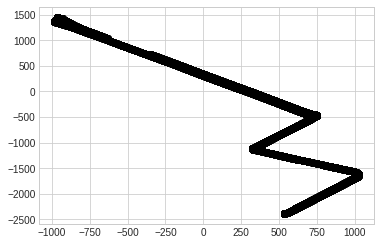

In [14]:
ego_translation_x = []
ego_translation_y = []
for i in range(0, len(zarr_dataset.frames)):
    frame = zarr_dataset.frames[i]
    ego_translation_x.append(frame[3][0])
    ego_translation_y.append(frame[3][1])
plt.plot(ego_translation_x, ego_translation_y, 'o', color='black')

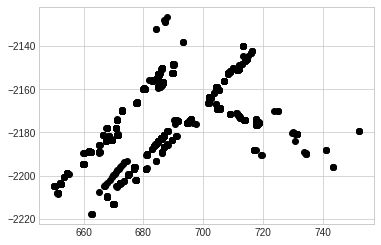

In [15]:
centroid_x = []
centroid_y = []
for i in range(0, 1000):#len(zarr_dataset.agents)):
    agent = zarr_dataset.agents[i]
    centroid = agent[0]
    centroid_x.append(centroid[0])
    centroid_y.append(centroid[1])
plt.plot(centroid_x, centroid_y, 'o', color='black')

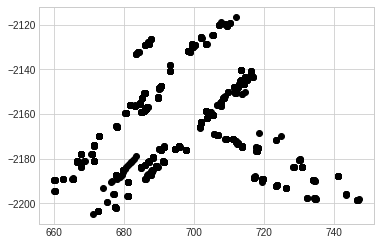

In [16]:
centroid_x = []
centroid_y = []
for i in range(1000, 2000):#len(zarr_dataset.agents)):
    agent = zarr_dataset.agents[i]
    centroid = agent[0]
    centroid_x.append(centroid[0])
    centroid_y.append(centroid[1])
plt.plot(centroid_x, centroid_y, 'o', color='black')

In [17]:
#centroid_x = []
#centroid_y = []
for i in range(0, 1000):#len(zarr_dataset.agents)):
    agent = zarr_dataset.agents[i]
    track_id = agent[4]
    print(track_id)
    #centroid = agent[0]
    #centroid_x.append(centroid[0])
    #centroid_y.append(centroid[1])
#plt.plot(centroid_x, centroid_y, 'o', color='black')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
1
2
3
8
9
10
12
14
18
20
21
22
23
24
25
26
27
28
29
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
1
2
3
8
9
10
12
14
18
20
21
22
28
33
36
37
38
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
1
3
8
9
10
12
14
20
21
22
28
33
36
37
38
44
45
46
48
49
51
52
53
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
1
3
8
9
10
12
14
20
21
22
28
33
36
37
38
44
45
46
48
49
51
52
53
55
56
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
7

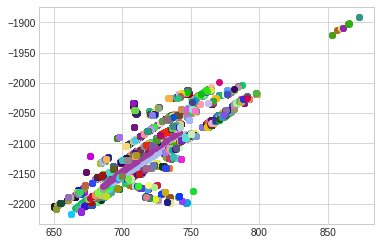

In [18]:

centroid_x = []
centroid_y = []

maxAgents = 1000
for i in range(0, maxAgents):
    centroid_x.append([])
    centroid_y.append([])
    
for i in range(0, 10000):#len(zarr_dataset.agents)):
    agent = zarr_dataset.agents[i]
    track_id = agent[4]
    if track_id < maxAgents + 1:
        #print(i)
        centroid = agent[0]
        centroid_x[int(track_id)-1].append(centroid[0])
        centroid_y[int(track_id)-1].append(centroid[1])

            
r = lambda: random.randint(0,255)
for i in range(0, maxAgents):
    plt.plot(centroid_x[i], centroid_y[i], 'o', color='#%02X%02X%02X' % (r(),r(),r()))


In [19]:
print(len(centroid_x))

print(len(centroid_x[0]))
print(len(centroid_x[1]))
print(len(centroid_x[2]))

1000
17
5
11


### traffic_light_faces

```
TL_FACE_DTYPE = [
    ("face_id", "<U16"),
    ("traffic_light_id", "<U16"),
    ("traffic_light_face_status", np.float32, (len(TL_FACE_LABELS,))),
]
```

In [20]:
#zarr_dataset.traffic_light_faces

print("tl_faces", zarr_dataset.tl_faces, "\n")

tl_face = zarr_dataset.tl_faces[0] # single traffic_light_face
print("tl_face", tl_face, "\n")

print("len(tl_faces)", len(zarr_dataset.tl_faces))
print("len(tl_face)", len(tl_face), "\n")

tl_id = tl_face[1]
tl_face_status = tl_face[2]

print(tl_face[0])
print(tl_id)
print(tl_face_status) # [active, inactive, unknown]

for i in range(0, 1000):
    tl_face = zarr_dataset.tl_faces[i] # single traffic_light_face
    tl_face_status = tl_face[2]
    if tl_face_status[0] > 0.2:
        print(tl_face)
        


tl_faces <zarr.core.Array '/traffic_light_faces' (316008,) [('face_id', '<U16'), ('traffic_light_id', '<U16'), ('traffic_light_face_status', '<f4', (3,))] read-only> 

tl_face ('xbVG', '/ggb', [0., 0., 1.]) 

len(tl_faces) 316008
len(tl_face) 3 

xbVG
/ggb
[0. 0. 1.]
('95kG', 'LL1i', [1., 0., 0.])


In [21]:
status = [0,0,0]
for i in range(0,len(zarr_dataset.tl_faces)):
    tl_face = zarr_dataset.tl_faces[i] # single traffic_light_face
    tl_face_status = tl_face[2]
    status = status + tl_face_status
    
    if i % int(len(zarr_dataset.tl_faces) / 100) == 0:
        print(str(round(i / len(zarr_dataset.tl_faces) * 100)) + "%", status)

print(status)
        

0% [0. 0. 1.]
1% [ 241.    0. 2920.]
2% [ 923.    0. 5398.]
3% [1619.    0. 7862.]
4% [ 2203.     0. 10438.]
5% [ 2808.     0. 12993.]
6% [ 3419.     0. 15542.]
7% [ 3996.     0. 18125.]
8% [ 4100.     0. 21181.]
9% [ 4298.     0. 24143.]
10% [ 4618.     0. 26983.]
11% [ 5138.     0. 29623.]
12% [ 5653.     0. 32268.]
13% [ 6227.     0. 34854.]
14% [ 6839.     0. 37402.]
15% [ 7431.     0. 39970.]
16% [ 7946.     0. 42615.]
17% [ 8609.     0. 45112.]
18% [ 9237.     0. 47644.]
19% [ 9758.     0. 50283.]
20% [ 9758.     0. 53443.]
21% [10110.     0. 56251.]
22% [10671.     0. 58850.]
23% [11333.     0. 61348.]
24% [12040.     0. 63801.]
25% [12464.     0. 66537.]
26% [12746.     0. 69415.]
27% [13020.     0. 72301.]
28% [13443.     0. 75038.]
29% [13636.     0. 78005.]
30% [14035.     0. 80766.]
31% [14534.     0. 83427.]
32% [15236.     0. 85885.]
33% [16109.     0. 88172.]
34% [16927.     0. 90514.]
35% [17130.     0. 93471.]
36% [17775.     0. 95986.]
37% [18592.     0. 98329.]
38% [

In [22]:
dataset_path = dm.require('scenes/test.zarr')
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   11314    |  1131400   |  88594921  |    7854144    |      31.43      |        100.00        |        78.31         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
